In [ ]:
# Using https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [ ]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

For GP regression:
- A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.

- A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.

- A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)

- A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).

- A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from torch.optim, and all trainable parameters of the model should be of type torch.nn.Parameter. Because GP models directly extend torch.nn.Module, calls to methods like model.parameters() or model.named_parameters() function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients

2. Call the model and compute the loss

3. Call backward on the loss to fill in gradients

4. Take a step on the optimizer

In [4]:
# this is for running the notebook in our testing framework
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.930   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.899   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.864   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.827   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.784   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.738   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.687   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.637   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.588   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.543   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.503   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.465   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.430   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.396   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.362   lengthscale: 0.244   noise: 0.216
Iter 16/50 - Loss: 0.329   lengthscale: 0.234   noise: 0.196
Iter 17/50 - Loss: 0.296   length

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a MultivariateNormal containing the prior mean and covariance from forward, a trained GP model in eval mode returns a MultivariateNormal containing the posterior mean and covariance.

If we denote a test point (test_x) as x* with the true output being y*, then model(test_x) returns the model posterior distribution p(f* | x*, X, y), for training data X, y. This posterior is the distribution over the function we are trying to model, and thus quantifies our model uncertainty.

In contrast, likelihood(model(test_x)) gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value. Recall in our problem setup

 
where 𝜖 is the likelihood noise for each observation. By including the likelihood noise which is the noise in your observation (e.g. due to noisy sensor), the prediction is over the observed value of the test point.

Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

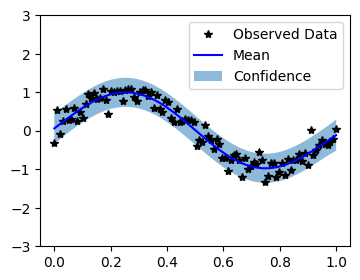

In [8]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])